In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy import interpolate
import pickle
from scipy import optimize


import xmeos
from xmeos import models
from xmeos import datamod

In [2]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)

In [3]:
# Set colorbar temperature properties
data = analysis['datasets']['Spera2011']
tbl = data['table']
delT = 500
tbl['Tlbl'] = delT*np.round(tbl['T']/delT)
Tlbl = np.unique(tbl['Tlbl'])
T_avg = data['T_avg']
cmap = plt.get_cmap('coolwarm',len(Tlbl))

In [4]:
tbl.head()

,V,T,P,E,trust,Verr,Terr,Perr,Eerr,T_label,V_label,Tlbl
0,14.173588,2559,-0.88,-20.738626,True,0,19,0.19,0.000083,2500.0,14.17,2500.0
1,14.173588,3058,-0.77,-20.569655,True,0,22,0.21,0.000021,3000.0,14.17,3000.0
2,14.173588,3537,-0.59,-20.409099,True,0,24,0.21,0.000021,3500.0,14.17,3500.0
3,14.173588,4005,-0.33,-20.256400,True,0,29,0.24,0.000041,4000.0,14.17,4000.0
4,14.173588,4484,0.01,-20.106291,True,0,32,0.24,0.000021,4500.0,14.17,4500.0


## Initialize RTPress EOS model

In [5]:
# Extract reference isotherm and roughly estimate 
#   compression parameters using interpolation
T0 = 4000
T0 = 3000

S0 = 0 # Ignore absolute entropy for simplicity

kind_compress = 'Vinet'
compress_path_const = 'T'
kind_gamma = 'GammaFiniteStrain'
kind_electronic = 'CvPowLaw'
# kind_RTpoly = 'logV'
kind_RTpoly = 'V' # V poly model has improved behavior at high compressions
RTpoly_order = 4
# RTpoly_order = 5
ref_energy_type='E0'
natom = 1
molar_mass = (24.31+28.09+3*16.0)/5.0 # g/(mol atom)

eos_mod = models.RTPressEos(kind_compress=kind_compress,
                            compress_path_const=compress_path_const,
                            kind_gamma=kind_gamma, kind_RTpoly=kind_RTpoly,
                            kind_electronic=kind_electronic,
                            apply_electronic=False,
                            RTpoly_order=RTpoly_order, ref_energy_type=ref_energy_type,
                            natom=natom, molar_mass=molar_mass
                           )
eos_mod.refstate.ref_state['T0'] = T0
eos_mod.set_param_values(S0, param_names='S0')


/Users/aswolf/Documents/projects/xmeos/xmeos/models/composite.py:1442: RuntimeWarning: divide by zero encountered in remainder
  if ((not np.isscalar(order)) | (order < 0) | (np.mod(order,0) !=0)):


## Extract and Fit Reference Isotherm
* Get Reference isotherm from data
* Determine compression EOS parameters by taking appropriate derivatives

In [6]:
analysis['props_3000']

{'KT': 21.24339187023094,
 'P': 0,
 'T': 3000,
 'V': 14.244863367785806,
 'alpha': 7.623747764458367e-05,
 'betaT': 0.04707346200214537,
 'dVdT': 0.001635}

In [7]:
# Extract reference isotherm and roughly estimate 
#   compression parameters using interpolation
msk_T0 = tbl['Tlbl']==T0
tbl_T0 = tbl.loc[msk_T0]
E0 = interpolate.pchip_interpolate(tbl_T0['P'],tbl_T0['E'],0)
V0 = interpolate.pchip_interpolate(tbl_T0['P'],tbl_T0['V'],0)
dVdP0 = interpolate.pchip_interpolate(tbl_T0['P'],tbl_T0['V'],0,der=1)
d2PdV20 = interpolate.pchip_interpolate(
    tbl_T0['V'][::-1],tbl_T0['P'][::-1],V0,der=2)
K0 = -V0*dVdP0
KP0 = -(1+V0*d2PdV20*dVdP0)

# V0 = analysis['props_3000']['V']
# K0 = .9*analysis['props_3500']['KT']
# KP0=6

rho_conv = 2.35023*14.1735882
# V0 = rho_conv*.408031
# K0 = 13.6262
# KP0 = 7.66573

print('E0 = ',E0)
# print('F0 = ',F0)
print('V0 = ',V0)
print('K0 = ',K0)
print('KP0 = ',KP0)


print('V0 = ',V0/rho_conv)
print('V/V4K = ',V0/rho_conv/.408031)

eos_mod.set_param_values([V0,K0,KP0,E0], ['V0','K0','KP0','E0'])

E0 =  -20.584834093350388
V0 =  13.162223495108455
K0 =  13.3340179793
KP0 =  6.95903325766
V0 =  0.395129163134
V/V4K =  0.968380253299


<IPython.core.display.Javascript object>


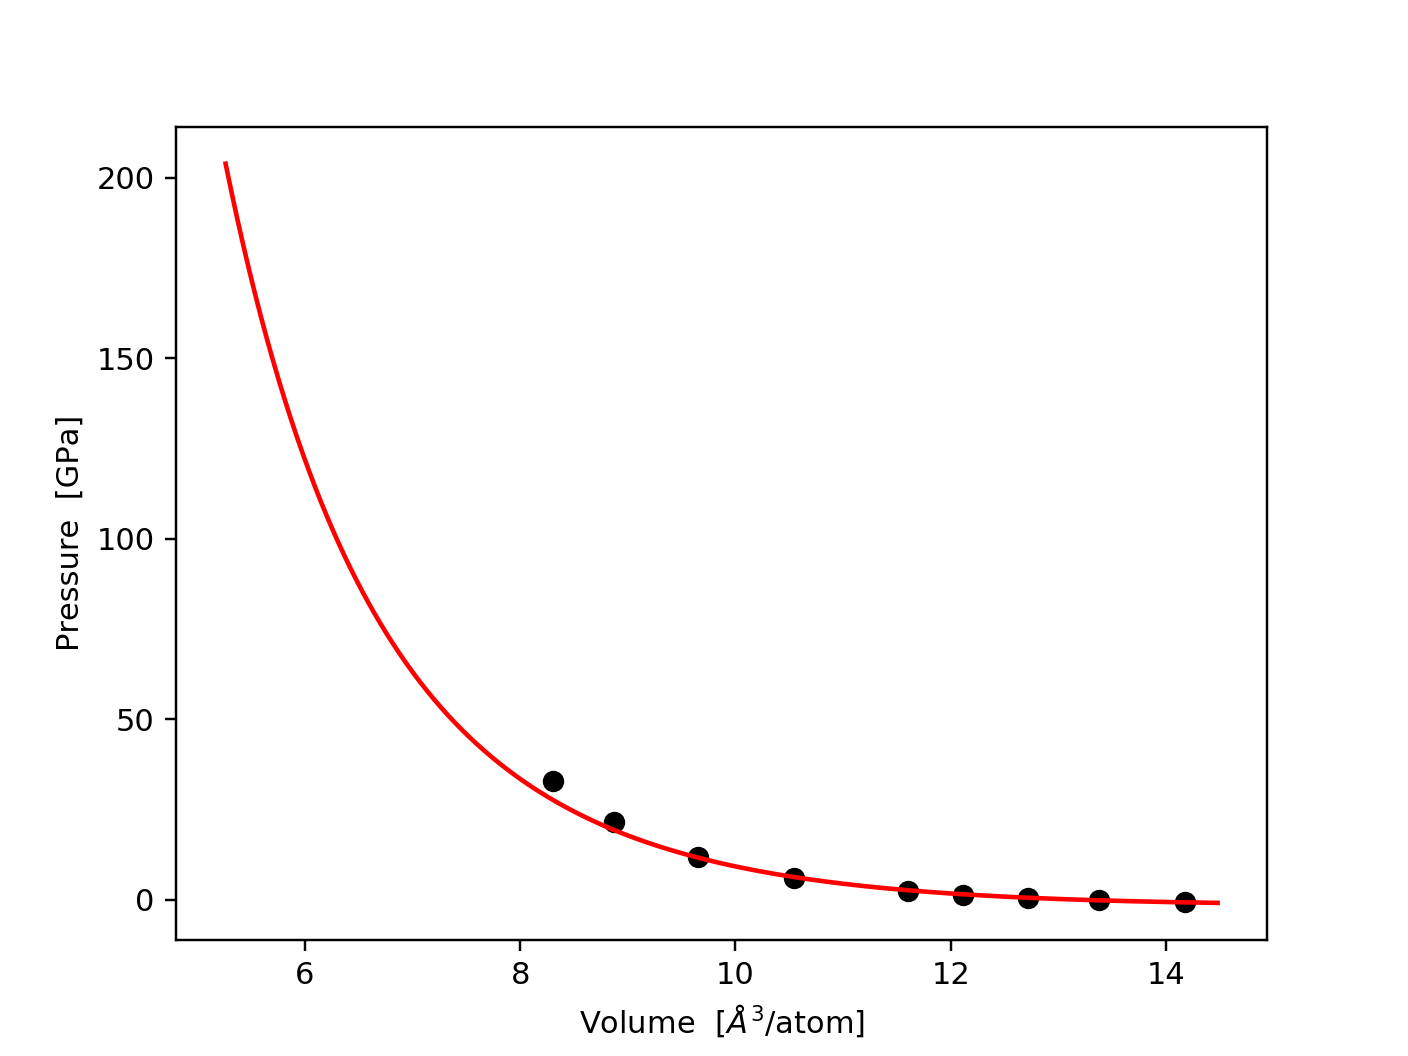

In [8]:
# Plot rough compress EOS as a Vinet model
eos_compress = models.CompressEos(kind=kind_compress, path_const='T')
eos_compress.set_param_values([V0,K0,KP0],param_names=['V0','K0','KP0'])

Vmod = V0*np.linspace(.4,1.1,1001)

plt.figure()
plt.plot(tbl_T0['V'],tbl_T0['P'],'ko')
plt.plot(Vmod, eos_compress.press(Vmod),'r-')
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Pressure  [GPa]')

## Roughly fit average Gruneisen gamma value
* Use Mie-Gruneisen linear relation between thermal energy and pressure to determine average numerical gamma value
* Roughly fit Finite Strain Gamma model that captures the overall trend

<IPython.core.display.Javascript object>


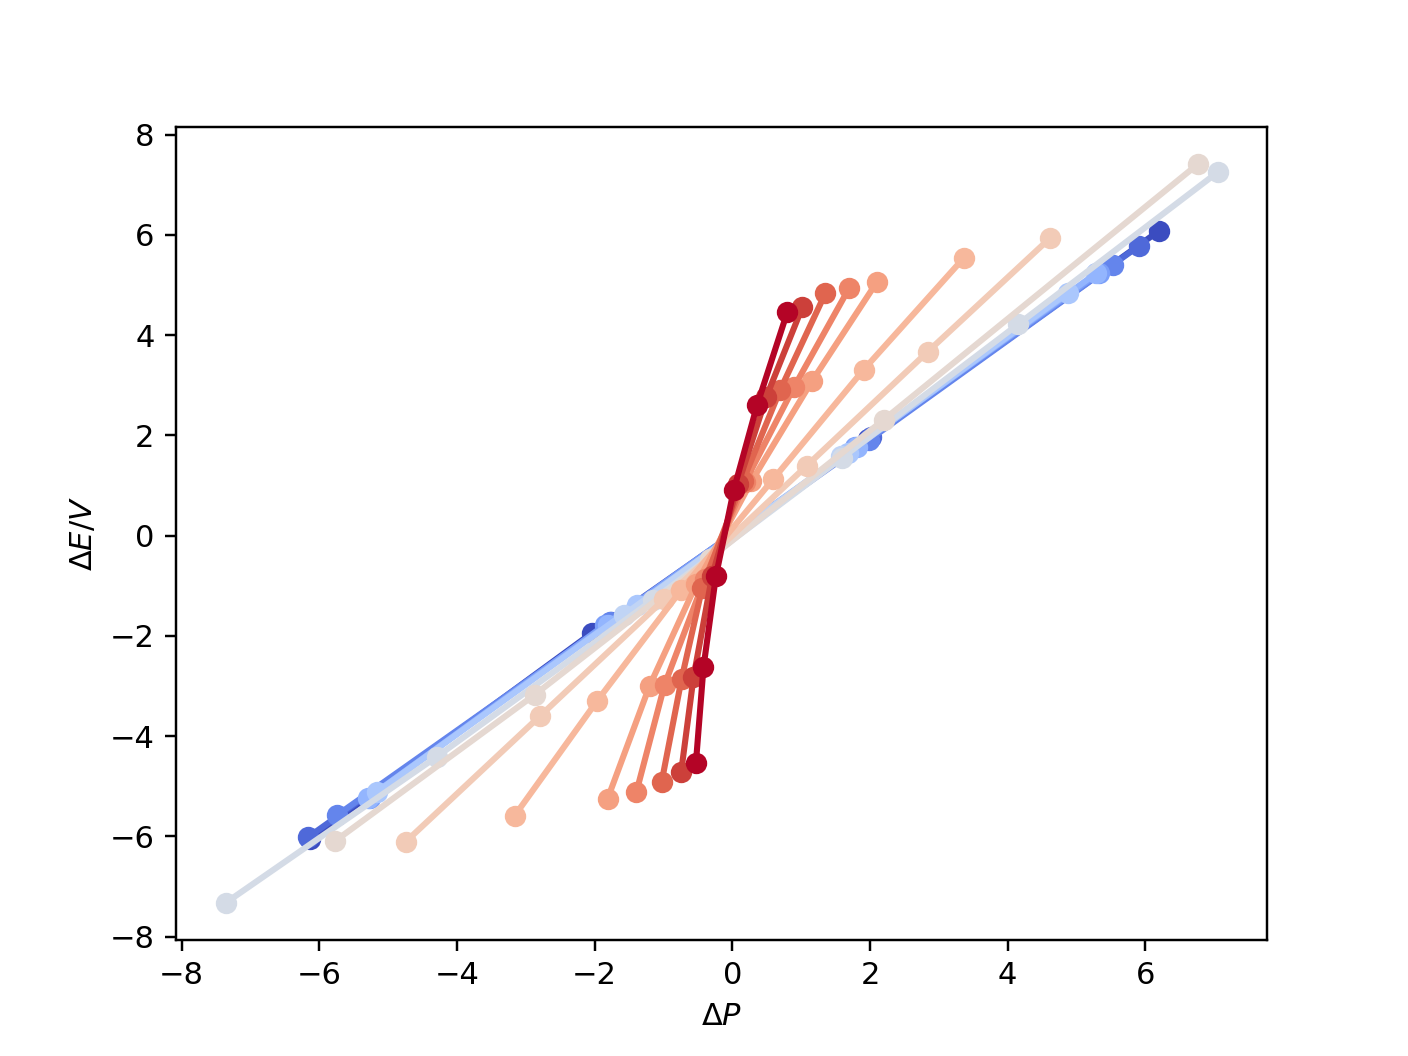

In [9]:
plt.figure()
Vuniq = np.unique(tbl['V'])
gamma_avg = np.zeros(Vuniq.size)
cmap = plt.get_cmap('coolwarm',len(Vuniq))

for ind, iV in enumerate(Vuniq):
    imask = (tbl['V']==Vuniq[ind])
    iE_V = models.CONSTS['PV_ratio']*tbl['E'][imask]/iV
    iP = tbl['P'][imask]
    ipoly = np.polyfit(iP,iE_V,1)
    plt.plot(iP-np.mean(iP),iE_V-np.mean(iE_V),'o-',
             color=cmap(ind/len(Vuniq)), lw=2)
    plt.xlabel(r'$\Delta P$')
    plt.ylabel(r'$\Delta E / V$')
    gamma_avg[ind] = 1/ipoly[0]
    

gamma_avg_md = pd.DataFrame(np.array([Vuniq,gamma_avg]).T,
                            columns=['V','gamma'])


<IPython.core.display.Javascript object>


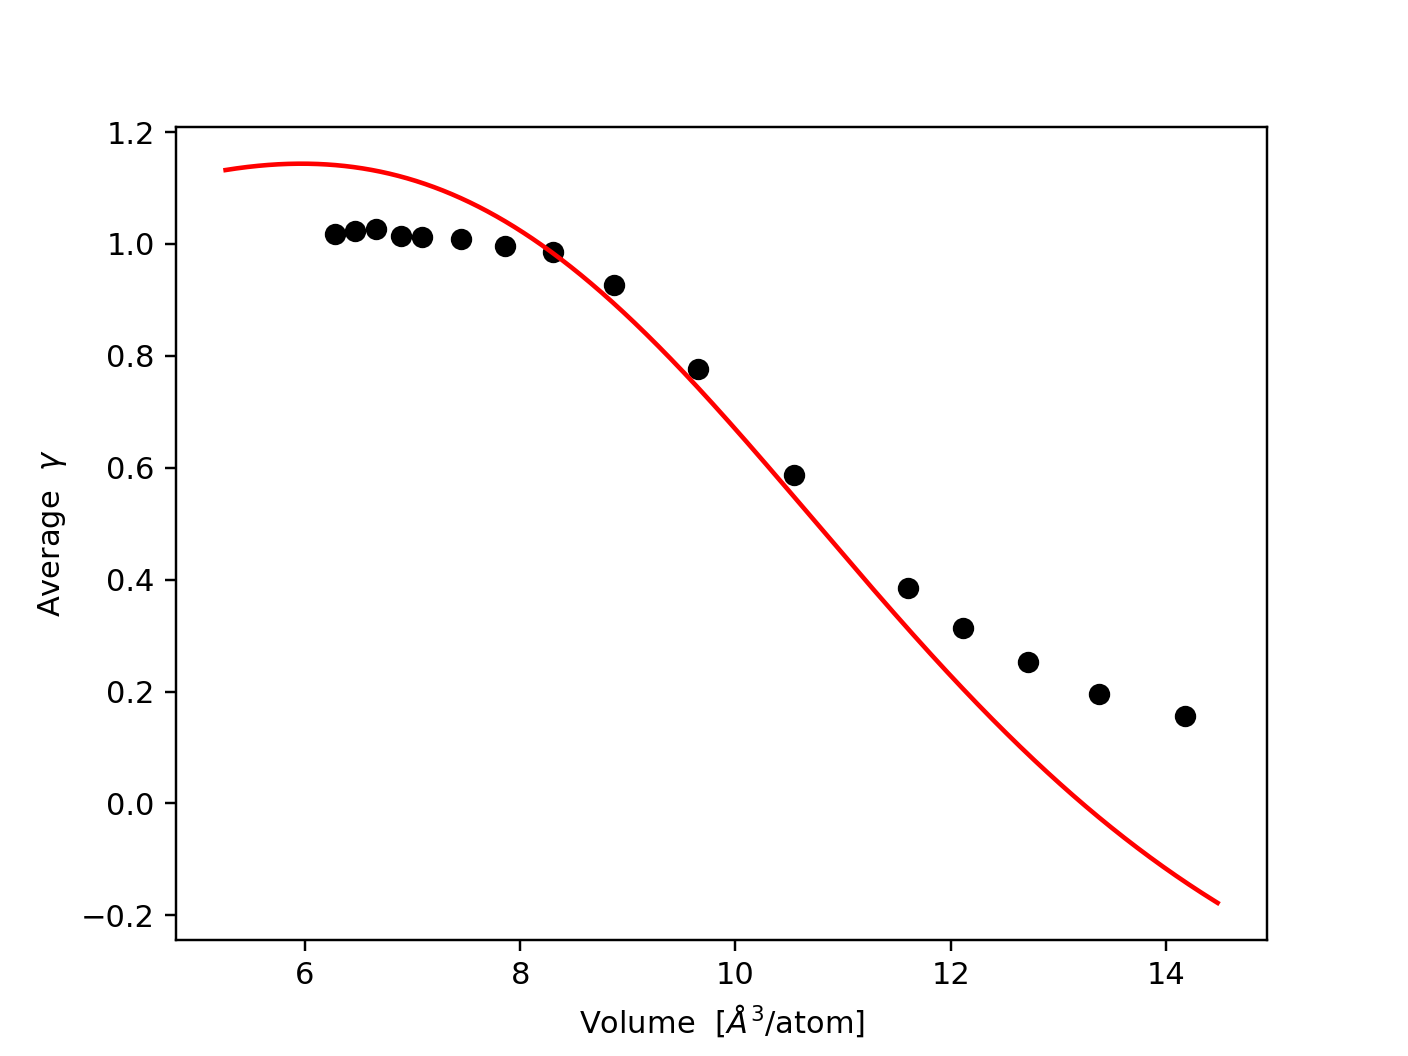

In [10]:
# Construct a rough model of average gamma values by hand tuning
kind_gamma = 'GammaFiniteStrain'
gamma0 = 0.01
gammap0 = -2.2
eos_gamma = models.GammaEos(kind=kind_gamma)
eos_gamma.set_param_values([V0,gamma0,gammap0],['V0','gamma0','gammap0'])

Vmod = V0*np.linspace(.4,1.1,1001)

plt.figure()
plt.plot(gamma_avg_md['V'], gamma_avg_md['gamma'],'ko')
plt.plot(Vmod, eos_gamma.gamma(Vmod), 'r-')
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Average  $\gamma$')

In [11]:
eos_mod.set_param_values([gamma0, gammap0], ['gamma0','gammap0'])

## Extract Constant-Volume Heat Capacity trends
* Extract constant-volume trends and fit Rosenfeld-Tarazona model to each
* Describe volume-dependence of Rosenfeld-Tarazona coefficient

<IPython.core.display.Javascript object>


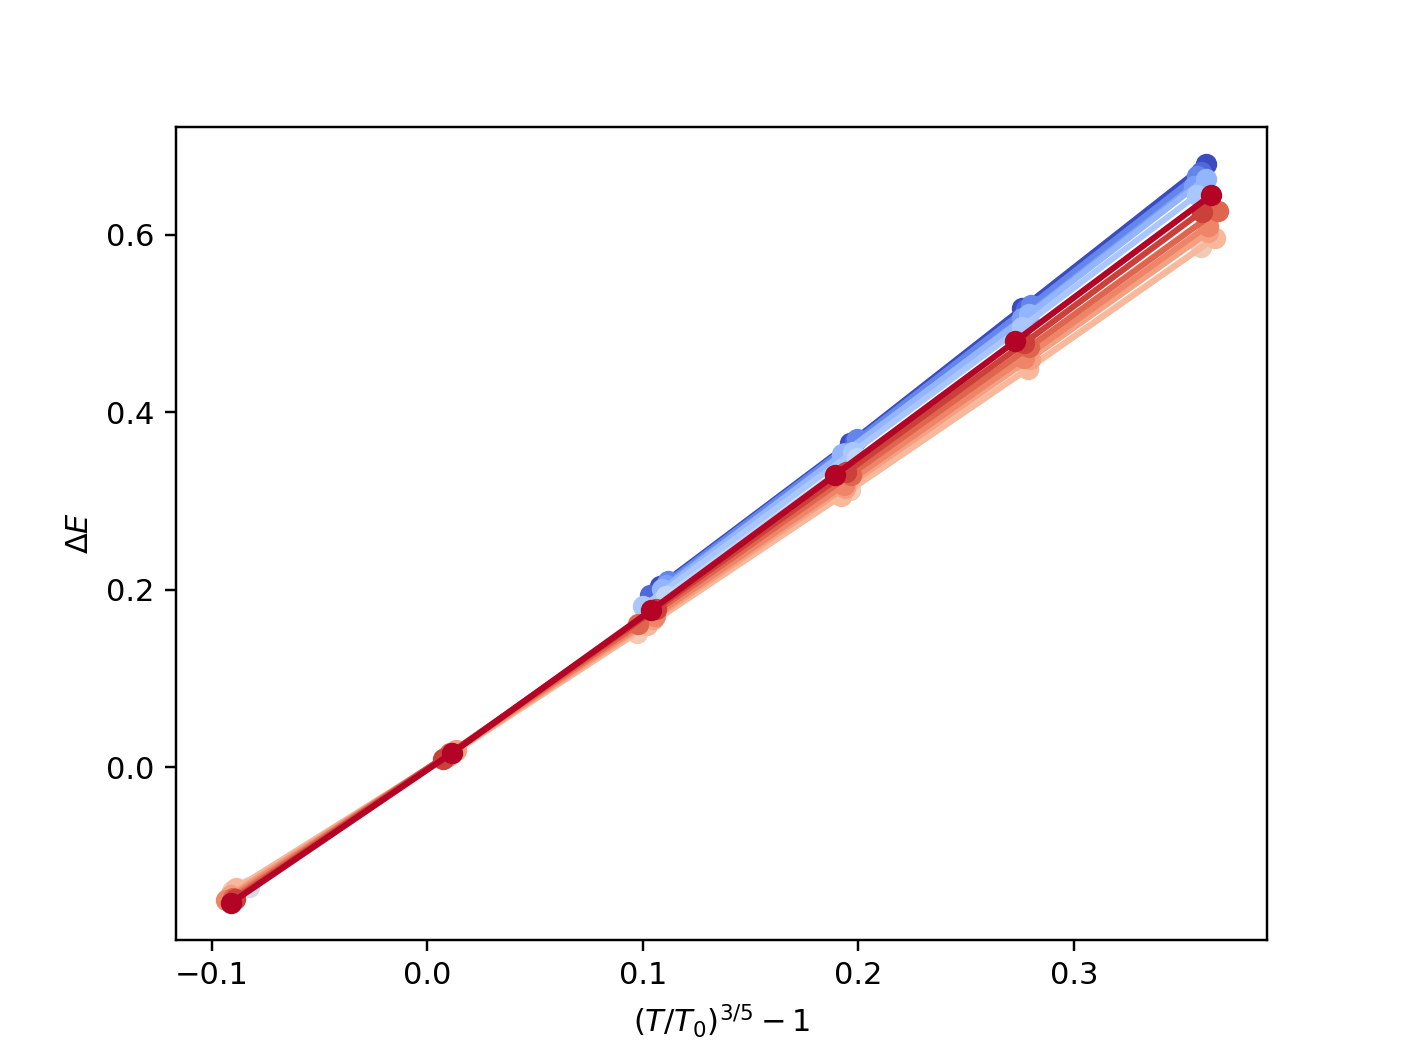

In [12]:
plt.figure()
Vuniq = np.unique(tbl['V'])
gamma_num = np.zeros(Vuniq.size)
cmap = plt.get_cmap('coolwarm',len(Vuniq))

mexp=3/5
bcoef_V = np.zeros(Vuniq.size)

for ind, iV in enumerate(Vuniq):
    imask = (tbl['V']==Vuniq[ind])
    iE = tbl['E'][imask]
    iT = tbl['T'][imask]
    itherm_perturb = (iT/T0)**mexp-1
    ipoly = np.polyfit(itherm_perturb,iE,1)
    plt.plot(itherm_perturb,iE-ipoly[1],'o-',
             color=cmap(ind/len(Vuniq)), lw=2)
    bcoef_V[ind] = ipoly[0]
    plt.xlabel(r'$(T/T_0)^{3/5}-1$')
    plt.ylabel(r'$\Delta E$')

In [13]:
V_dev = eos_mod.calc_RT_vol_dev(Vuniq)
bpoly = np.polyfit(V_dev, bcoef_V, RTpoly_order)
bcoefs = bpoly[::-1]

bcoef_param_names = eos_mod.get_array_param_names('bcoef')
eos_mod.set_param_values(bcoefs, param_names=bcoef_param_names)
print('b-coefficients = ', np.round(bcoefs,decimals=3))

b-coefficients =  [  1.728   0.669  -2.892 -20.25  -21.419]


<IPython.core.display.Javascript object>


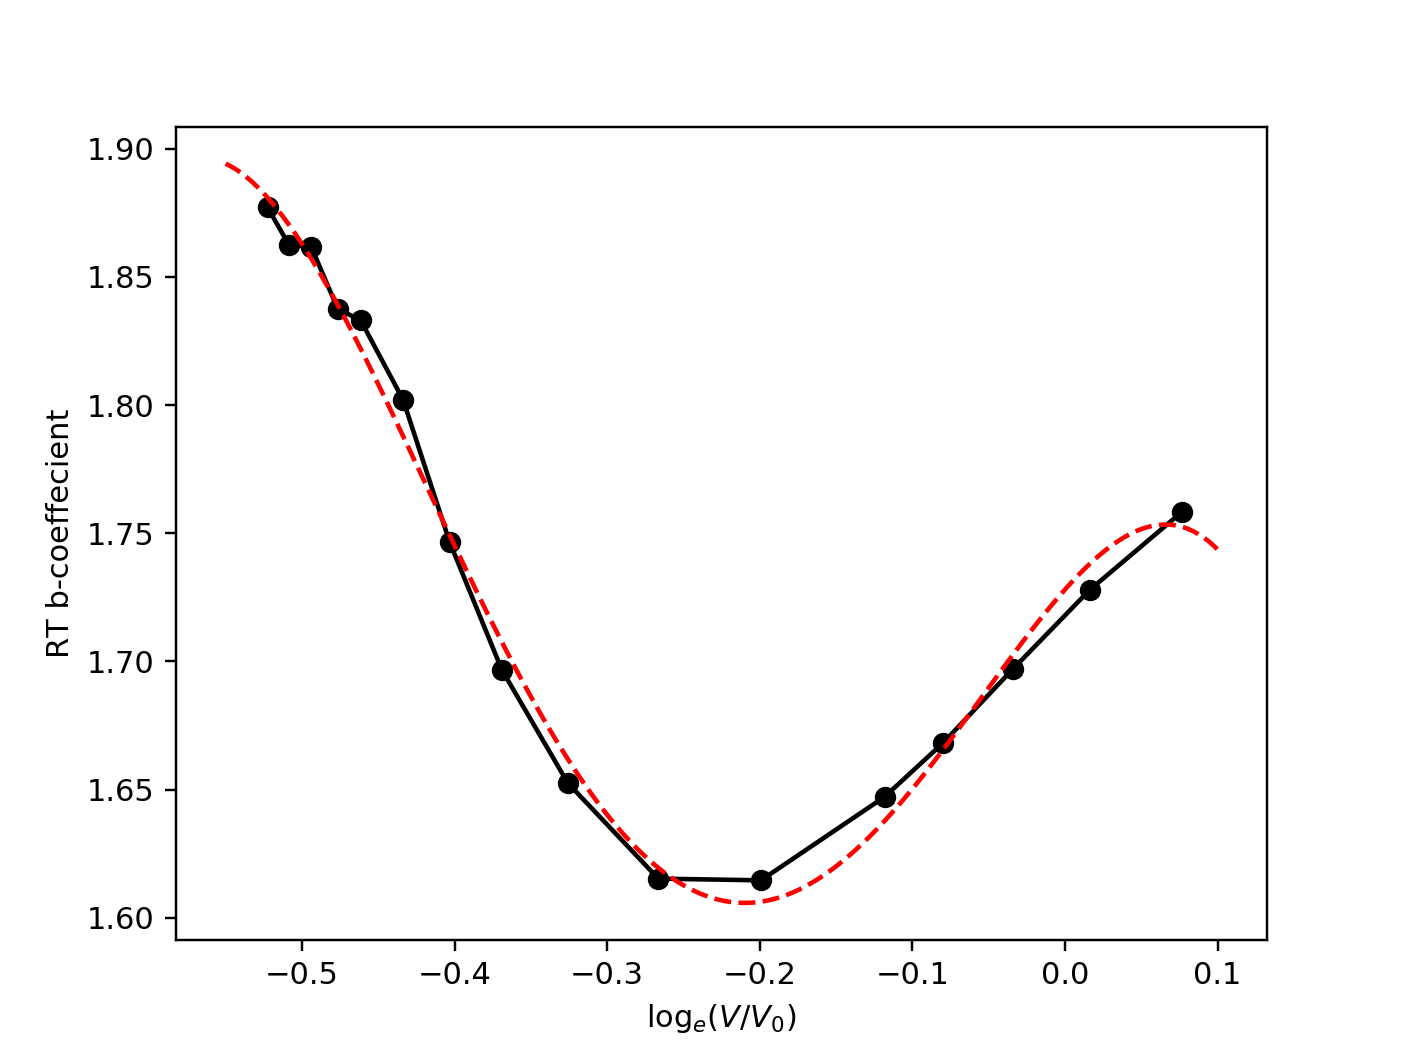

In [14]:
Vmod = V0*np.linspace(.45,1.1,1001)
Vmod_dev = eos_mod.calc_RT_vol_dev(Vmod)

plt.figure()
plt.plot(V_dev, bcoef_V,'ko-')
# plt.plot(Vmod_dev, np.polyval(bpoly, Vmod_dev),'r--')
plt.plot(Vmod_dev, eos_mod.calc_RTcoefs(Vmod),'r--')
plt.xlabel(r'$\log_e (V/V_0)$')
plt.ylabel('RT b-coeffecient')

## Review Rough Initial EOS parameter guesses

In [15]:
Vmod = V0*np.linspace(.4,1.1,1001)
params_init = eos_mod.get_params()

In [16]:
# Define pretty latex printing
param_tex_str = {}
param_tex_str['V0'] = r"$V_0$"
param_tex_str['K0'] = r"$K_0$"
param_tex_str['KP0'] = r"$K'_0$"
param_tex_str['gamma0'] = r"$\gamma_0$"
param_tex_str['gammap0'] = r"$\gamma'_0$"
param_tex_str['mexp'] = r"$m$"
param_tex_str['Cvlimfac'] = r"$C_V^{\rm lim}$"
param_tex_str['S0'] = r"$S_0$"
param_tex_str['E0'] = r"$E_0$"
for ind in np.arange(RTpoly_order+1):
    param_tex_str['_bcoef_{:d}'.format(ind)] = r"$b_{:d}$".format(ind)
    
    
# param_tex_str['_bcoef_0'] = r"$b_0$"
# param_tex_str['_bcoef_1'] = r"$b_1$"
# param_tex_str['_bcoef_2'] = r"$b_2$"
# param_tex_str['_bcoef_3'] = r"$b_3$"
# param_tex_str['_bcoef_4'] = r"$b_4$"

In [17]:
param_tex_str

{'Cvlimfac': '$C_V^{\\rm lim}$',
 'E0': '$E_0$',
 'K0': '$K_0$',
 'KP0': "$K'_0$",
 'S0': '$S_0$',
 'V0': '$V_0$',
 '_bcoef_0': '$b_0$',
 '_bcoef_1': '$b_1$',
 '_bcoef_2': '$b_2$',
 '_bcoef_3': '$b_3$',
 '_bcoef_4': '$b_4$',
 'gamma0': '$\\gamma_0$',
 'gammap0': "$\\gamma'_0$",
 'mexp': '$m$'}

In [18]:
analysis['gamma_avg_md'] = gamma_avg_md
analysis['params_init'] = params_init
analysis['eos_mod'] = eos_mod
analysis['param_tex_str'] = param_tex_str
with open(analysis_file, 'wb') as f:
    pickle.dump(analysis, f)

## View Rough Initial Guess for ALL data
* This is obviously not the best model, but it is at least in the neighborhood of a reasonable model
* This rough model will act as an initial guess for model fitting

<IPython.core.display.Javascript object>


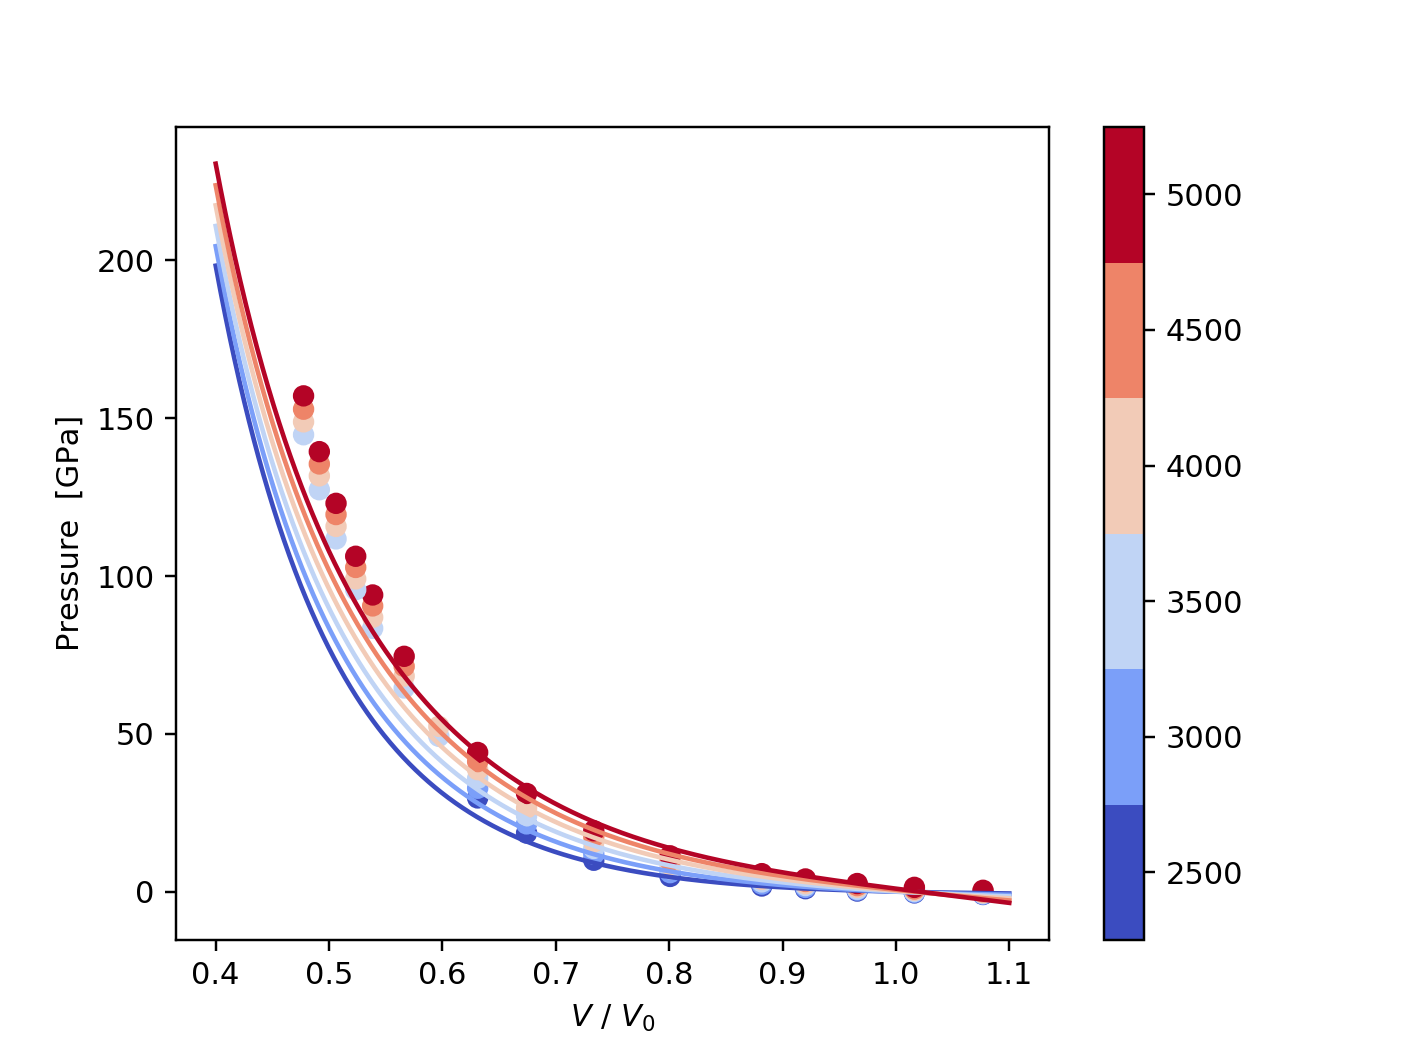

<IPython.core.display.Javascript object>


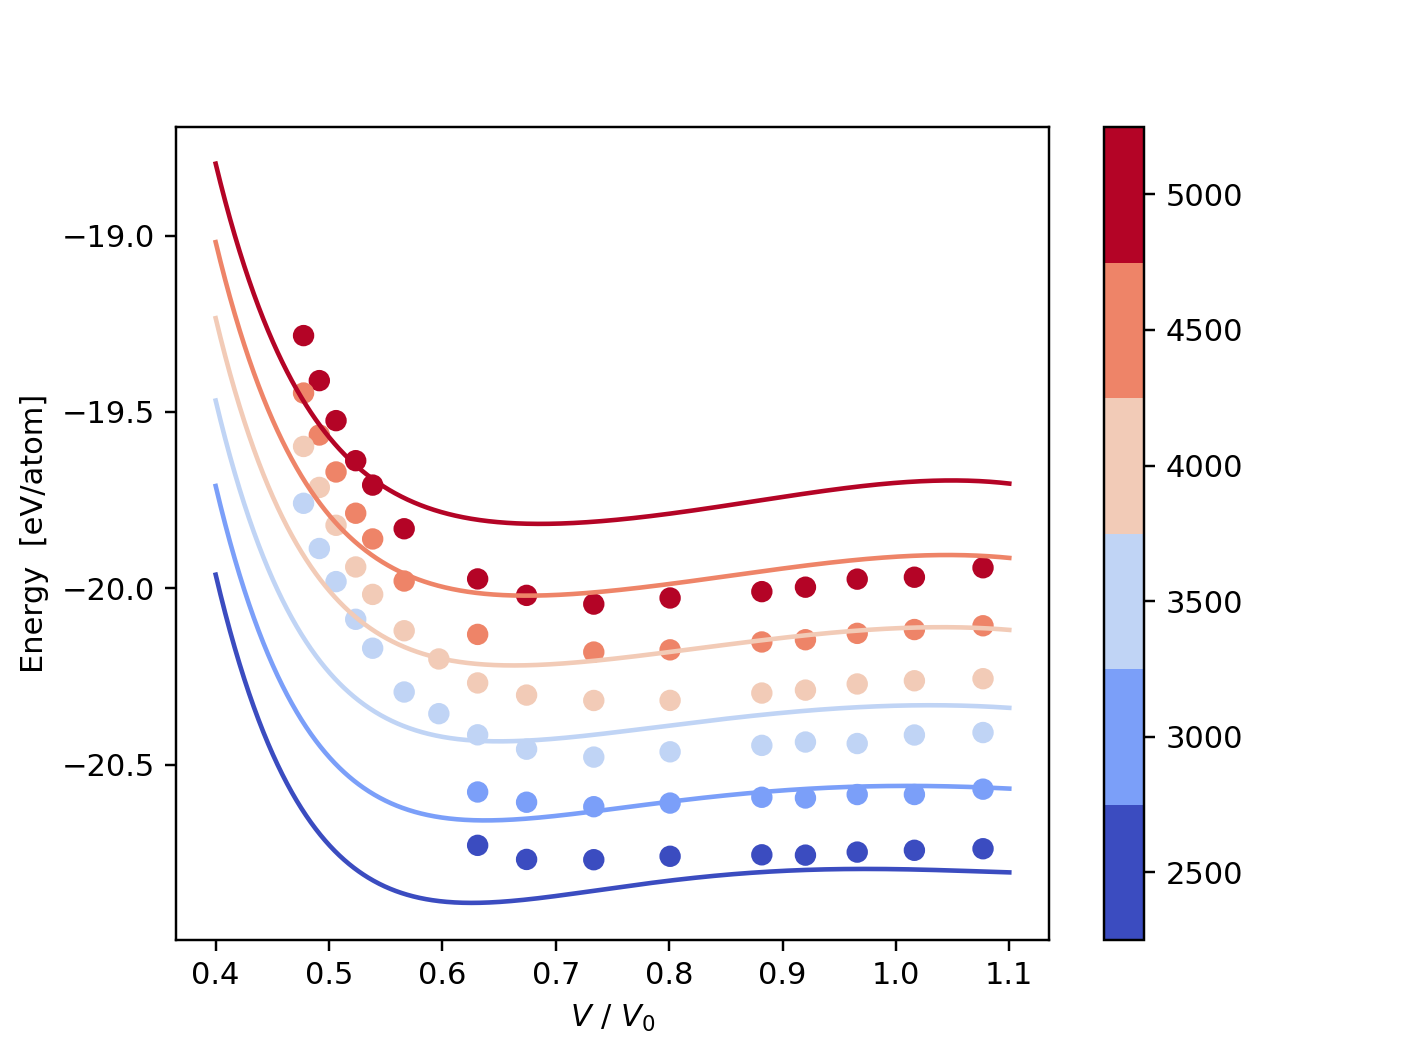

In [19]:
cmap = plt.get_cmap('coolwarm',len(Tlbl))
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]


plt.figure()
for iT in data['T_avg']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.press(Vmod,iT), '-', color=icol)
    
plt.scatter(tbl['V']/V0,tbl['P'],c=tbl['T'], cmap=cmap)
plt.clim(clims)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(Tlbl)



plt.figure()
for iT in data['T_avg']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.internal_energy(Vmod,iT), '-', color=icol)
    
plt.scatter(tbl['V']/V0,tbl['E'],c=tbl['T'], cmap=cmap)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Energy  [eV/atom]')
plt.colorbar()
plt.clim(clims)
cbar.set_ticks(Tlbl)

